In [1]:
import importlib as imp
import spotiphy
import numpy as np
import scanpy as sc
import squidpy as sq
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import spotiphy
import seaborn as sns

In [2]:
adata_st = sc.read_h5ad("F:/Ziqian Zheng/Spotiphy_data/Simulated ST/Simulated_ST_221_1.h5ad")
results_folder = 'Simulations/simulation1/'
type_list = adata_st.uns['type_list']
type_list_RCTD = [s.replace('/', '') for s in type_list]
type_list_RCTD = [s.replace(' ', '.') for s in type_list_RCTD]
# cluster_annotation = pd.read_csv(results_folder+'NCF221D_meta_seurat_cluster.txt', index_col=0, header=None,
#                                  delimiter='\t')
cluster_annotation = pd.read_csv(results_folder+'NCF221D_meta_seurat_cluster.csv', index_col=0, header=0,
                                 delimiter=',')
# for i in range(len(cluster_annotation)):
#     if adata_st.obs_names[i] in cluster_annotation.index:
#         adata_st.obs.loc[adata_st.obs_names[i], 'Region'] = cluster_annotation.loc[adata_st.obs_names[i], 1]
adata_st.obs['Region'] = [str(int(i)) for i in cluster_annotation.values]

In [3]:
cell_count_truth = adata_st.obsm['ground_truth']
proportion_truth = cell_count_truth/np.sum(cell_count_truth, axis=1, keepdims=True)
proportion_spotiphy = np.load(results_folder+'proportion_spotiphy.npy')
proportion_tangram = np.load(results_folder+'proportion_tangram.npy')
proportion_c2l = np.load(results_folder+'proportion_c2l.npy')
proportion_CARD = pd.read_csv(results_folder+'Proportion_CARD.csv', index_col=0, header=0)
proportion_CARD = proportion_CARD.reindex(adata_st.obs_names)
proportion_CARD = proportion_CARD[type_list].values
proportion_cyto = pd.read_csv(results_folder+'Proportion_CytoSPACE.csv', index_col=0, header=0)
proportion_cyto = proportion_cyto.reindex(adata_st.obs_names)
proportion_cyto = proportion_cyto[type_list].values
proportion_RCTD = pd.read_csv(results_folder+'Proportion_RCTD.csv', index_col=0, header=0)
proportion_RCTD = proportion_RCTD.reindex(adata_st.obs_names)
proportion_RCTD = proportion_RCTD[type_list_RCTD].values
methods = ['Spotiphy', 'Tangram', 'Cell2location', 'CARD', 'CytoSPACE', 'RCTD']
proportion_estimated = [proportion_spotiphy, proportion_tangram, proportion_c2l, proportion_CARD, proportion_cyto, proportion_RCTD]
proportion_dict = {k:v for k, v in zip(methods, proportion_estimated)}

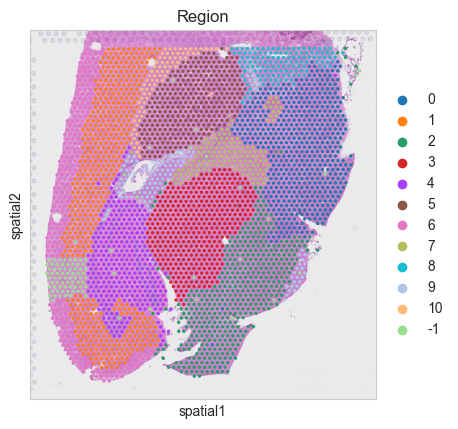

In [4]:
sc.pl.spatial(adata_st, color='Region', cmap='tab20')

deconvolution.py (334): Passing `palette` without assigning `hue` is deprecated.


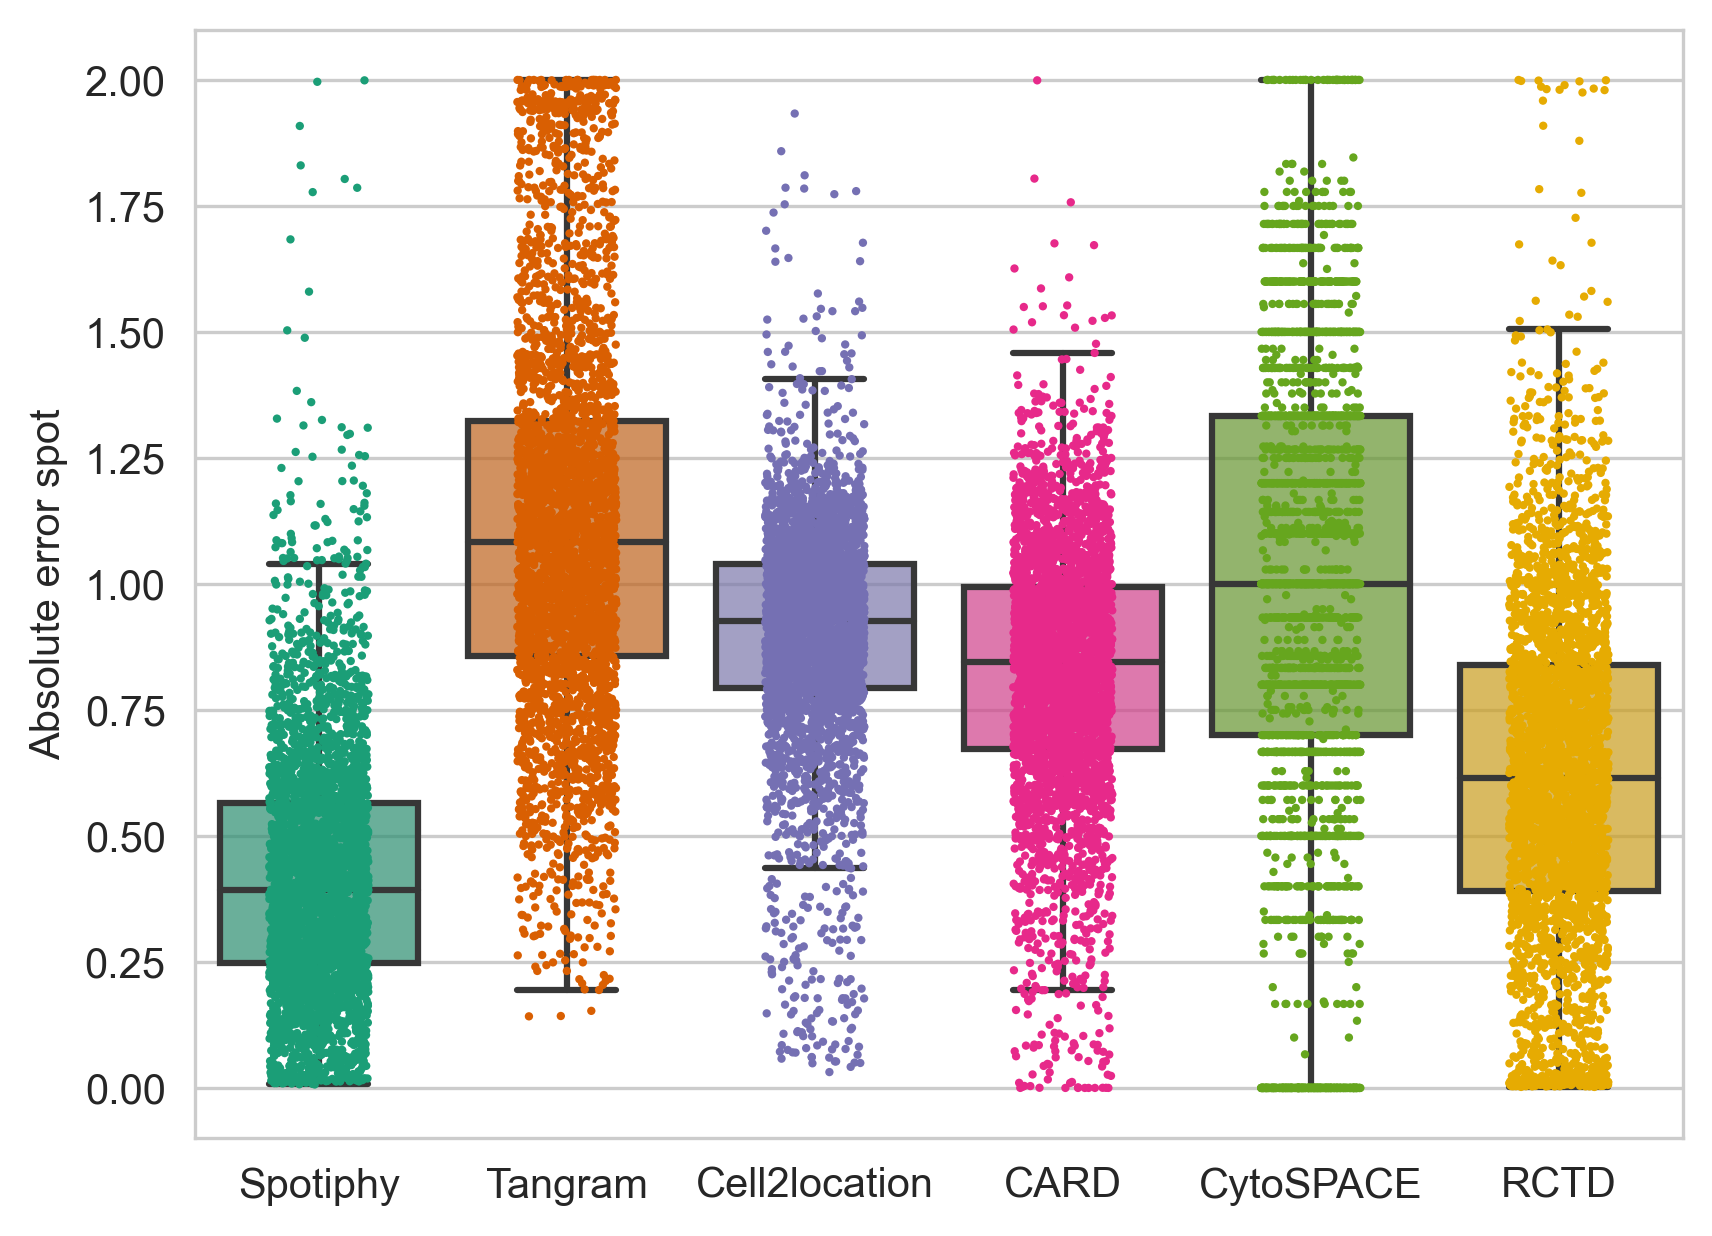

In [10]:
imp.reload(spotiphy.deconvolution)
Eval = spotiphy.deconvolution.Evaluation(proportion_truth, proportion_estimated, methods, out_dir=results_folder,
                                         cluster=adata_st.obs['Region'].values, type_list=type_list)
Eval.plot_metric(save=True, metric='Absolute error spot')

In [ ]:
type_list_truth = [type +'_truth' for type in type_list]
adata_st.obs[type_list_truth] = proportion_truth
type_list_method = []
for method in methods:
    type_list_method.append([type +'_' + method for type in type_list])
    adata_st.obs[type_list_method[-1]] = proportion_dict[method]

In [80]:
%matplotlib agg
%matplotlib agg
adata_st.var.rename(index={'Lamp5': 'Lamp5_g', 'Pvalb': 'Pvalb_g', 'Sst': 'Sst_g', 'Vip': 'Vip_g', 'Sncg': 'Sncg_g'},
                    inplace=True)
with mpl.rc_context({'figure.figsize': [5, 5], 'figure.dpi': 800}):
    for i in range(len(type_list)):
        vmax = np.quantile(proportion_truth[:, i], 0.98)
        vmax = max(vmax, 0.05)
        color_key = type_list_truth[i]
        ax = sc.pl.spatial(adata_st, cmap='magma', color=color_key, img_key=None, vmin=0, vmax=vmax,
                           size=1.3, show=False)
        color_key = "".join(x for x in color_key if x!='/')
        ax[0].get_figure().savefig(results_folder + 'proportion figures/' + color_key + '.png')
        for j in range(len(methods)):
            color_key = type_list_method[j][i]
            ax = sc.pl.spatial(adata_st, cmap='magma', color=color_key, img_key=None, vmin=0.001, vmax=vmax,
                               size=1.3, show=False)
            color_key = "".join(x for x in color_key if x!='/')
            ax[0].get_figure().savefig(results_folder + 'proportion figures/' + color_key + '.png')

709011978.py (6): The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


<Figure size 1920x1440 with 0 Axes>

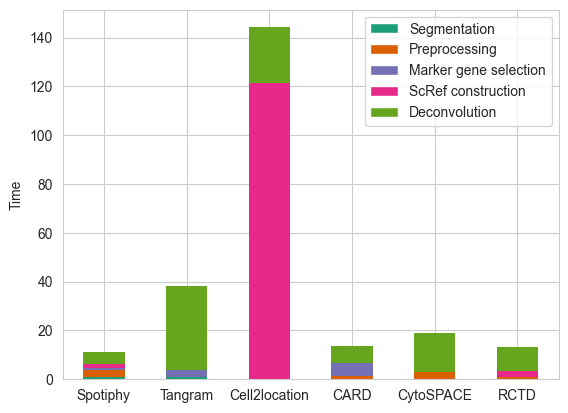

In [36]:
import matplotlib.cm as cm
time = pd.read_excel(results_folder+'Time.xlsx', index_col=0, header=0).iloc[:5, :10]
time = time[methods]
time = time.fillna(0).T
plt.figure(dpi=300)
cmap = cm.get_cmap('Dark2')
colors = [cmap(i) for i in range(8)]
ax = time.plot(kind='bar', stacked=True, color=colors, rot=0)
plt.setp(ax.patches, linewidth=0)
plt.ylabel('Time')
ax.get_figure().savefig(results_folder+'figures/stacked_time', dpi=300)

In [ ]:
plt.figure(dpi=300)
ax = time['Deconvolution'].plot(kind='bar', color=colors, rot=0)
plt.setp(ax.patches, linewidth=0)
plt.ylabel('Deconvolution time')
ax.get_figure().savefig(results_folder+'figures/time', dpi=300)

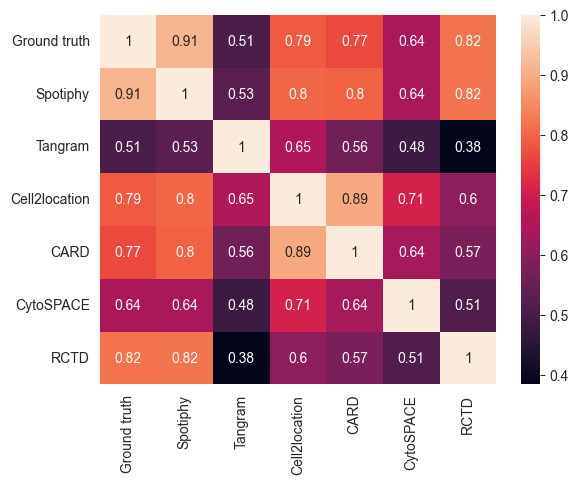

In [39]:
proportion_agg = np.vstack([proportion_truth.flatten()+1e-8] + [proportion.flatten()+1e-8 for proportion in proportion_estimated])
corr_matrix = np.corrcoef(proportion_agg)
plt.grid(False)
sns.heatmap(corr_matrix, xticklabels=['Ground truth']+methods, yticklabels=['Ground truth']+methods, annot=True)
plt.savefig(results_folder+'figures/correlation', dpi=400)

In [40]:
print(corr_matrix)

[[1.         0.91202461 0.50671388 0.78770241 0.76601466 0.64210517
  0.81825378]
 [0.91202461 1.         0.52999701 0.8020955  0.79781714 0.64069086
  0.81990233]
 [0.50671388 0.52999701 1.         0.6491513  0.55982755 0.48075809
  0.38423382]
 [0.78770241 0.8020955  0.6491513  1.         0.89452374 0.70839974
  0.60367395]
 [0.76601466 0.79781714 0.55982755 0.89452374 1.         0.63855939
  0.57497706]
 [0.64210517 0.64069086 0.48075809 0.70839974 0.63855939 1.
  0.51340863]
 [0.81825378 0.81990233 0.38423382 0.60367395 0.57497706 0.51340863
  1.        ]]


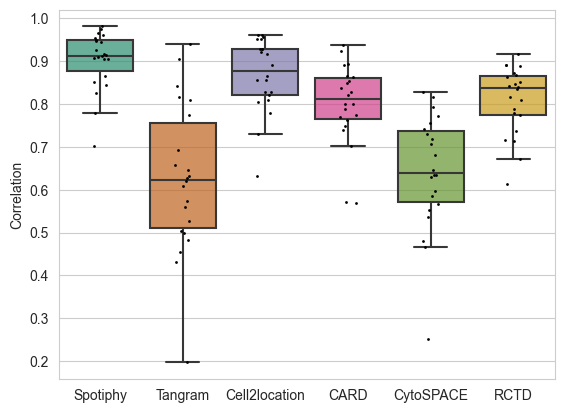

In [43]:
imp.reload(spotiphy.deconvolution)
Eval = spotiphy.deconvolution.Evaluation(proportion_truth, proportion_estimated, methods, out_dir=results_folder,
                                         cluster=adata_st.obs['Region'].values)
Eval.plot_metric_type(save=True, metric='Correlation')

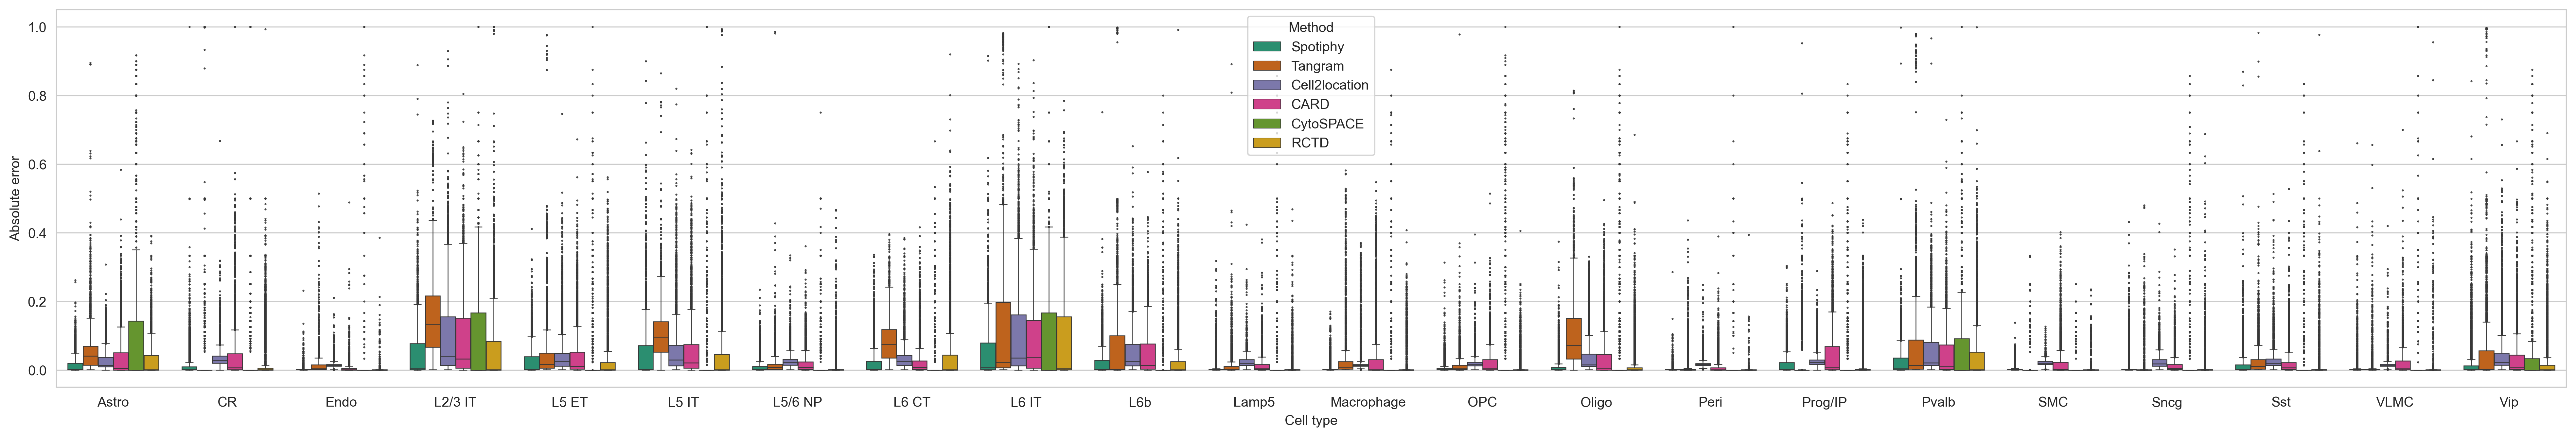

In [37]:
imp.reload(spotiphy.deconvolution)
Eval = spotiphy.deconvolution.Evaluation(proportion_truth, proportion_estimated, methods, out_dir=results_folder,
                                         cluster=adata_st.obs['Region'].values, type_list=type_list)
Eval.plot_metric_all(save=True, metric='Absolute error')

850